**1. Importaciones**

---

Importa bibliotecas esenciales para manipulación de imágenes (cv2), sistema de archivos (os), operaciones numéricas (numpy), TensorFlow/Keras para el modelo, visualización (matplotlib, seaborn), manejo de datos (pandas), utilidades (glob, collections, itertools), y herramientas específicas de Colab.

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
import seaborn as sns
from tqdm import tqdm
import itertools
import glob
from collections import Counter
%matplotlib inline

**2.  Preparación del Dataset:**

---

Luego, se prepara el dataset. Se crean los directorios necesarios, se descarga un archivo ZIP con las imágenes de los Simpsons desde Google Drive, se descomprime este archivo y finalmente se verifica que la estructura de carpetas resultante sea la correcta.  Esto asegura que los datos estén listos para ser procesados por el modelo.

In [ ]:
# Crear directorios base
!mkdir -p /content/simpsons

# Descargar el archivo del dataset
!gdown 1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La -O /content/archive.zip

# Descomprimir el archivo ZIP
!unzip -q /content/archive.zip -d /content/simpsons

# Verificar la estructura extraída
print("Estructura de carpetas extraídas:")
!ls -la /content/simpsons

Downloading...
From (original): https://drive.google.com/uc?id=1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La
From (redirected): https://drive.google.com/uc?id=1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La&confirm=t&uuid=d3a8d9cf-5c29-46bd-9fa2-5611e7dd233e
To: /content/archive.zip
100% 1.16G/1.16G [00:20<00:00, 55.7MB/s]
Estructura de carpetas extraídas:
total 81304
drwxr-xr-x  4 root root     4096 May 15 23:38 .
drwxr-xr-x  1 root root     4096 May 15 23:38 ..
-rw-r--r--  1 root root   491788 Sep 20  2019 annotation.txt
-rw-r--r--  1 root root   598494 Sep 20  2019 characters_illustration.png
drwxr-xr-x  3 root root     4096 May 15 23:38 kaggle_simpson_testset
-rw-r--r--  1 root root     1452 Sep 20  2019 number_pic_char.csv
drwxr-xr-x 45 root root     4096 May 15 23:38 simpsons_dataset
-rw-r--r--  1 root root 82136544 Sep 20  2019 weights.best.hdf5


**3.  Configuración de Rutas:**

---


A continuación, se definen las rutas a las carpetas que contienen las imágenes de entrenamiento y prueba. Se comprueba que estas rutas sean válidas, lo cual es crucial para que el programa pueda acceder a los datos.

In [ ]:

# Según las imágenes proporcionadas, configuramos las rutas correctas
# Carpetas de entrenamiento y prueba según tu estructura
DATASET_TRAIN_PATH = "/content/simpsons/simpsons_dataset"
DATASET_TEST_PATH = "/content/simpsons/kaggle_simpson_testset"

# Verificar que las carpetas existen
print(f"\nCarpeta de entrenamiento existe: {os.path.exists(DATASET_TRAIN_PATH)}")
print(f"Carpeta de prueba existe: {os.path.exists(DATASET_TEST_PATH)}")


Carpeta de entrenamiento existe: True
Carpeta de prueba existe: True


**4.  Análisis del Dataset de Entrenamiento:**

---


Se realiza un análisis del dataset de entrenamiento para entender su contenido. Se cuenta cuántas clases (personajes) hay, se muestran ejemplos de nombres de personajes y se determina cuántas imágenes hay por cada uno. Se identifican los personajes con más imágenes, lo que puede ser útil para entender la distribución de los datos. Si la carpeta no tiene la estructura esperada, se imprime un mensaje de error.

In [ ]:
# Contar personajes y mostrar estadísticas si las carpetas existen
if os.path.exists(DATASET_TRAIN_PATH):
    # Comprobar si hay subcarpetas (personajes)
    if any(os.path.isdir(os.path.join(DATASET_TRAIN_PATH, f)) for f in os.listdir(DATASET_TRAIN_PATH)):
        train_classes = [d for d in os.listdir(DATASET_TRAIN_PATH) if os.path.isdir(os.path.join(DATASET_TRAIN_PATH, d))]
        print(f"\nNúmero de personajes en el dataset de entrenamiento: {len(train_classes)}")
        print(f"Ejemplos de personajes: {train_classes[:5]}")

        # Contar imágenes por personaje
        train_images_count = {}
        total_train_images = 0

        for character in train_classes:
            char_path = os.path.join(DATASET_TRAIN_PATH, character)
            images = [f for f in os.listdir(char_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            train_images_count[character] = len(images)
            total_train_images += len(images)

        print(f"Total de imágenes de entrenamiento: {total_train_images}")
        print("\nPersonajes con más imágenes:")
        for char, count in sorted(train_images_count.items(), key=lambda x: x[1], reverse=True)[:18]:
            print(f"{char}: {count} imágenes")
    else:
        print("La carpeta de entrenamiento no parece contener subdirectorios de personajes.")
        print("Contenido de la carpeta de entrenamiento:")
        !ls -la {DATASET_TRAIN_PATH}


Número de personajes en el dataset de entrenamiento: 43
Ejemplos de personajes: ['moe_szyslak', 'otto_mann', 'disco_stu', 'principal_skinner', 'kent_brockman']
Total de imágenes de entrenamiento: 20933

Personajes con más imágenes:
homer_simpson: 2246 imágenes
ned_flanders: 1454 imágenes
moe_szyslak: 1452 imágenes
lisa_simpson: 1354 imágenes
bart_simpson: 1342 imágenes
marge_simpson: 1291 imágenes
krusty_the_clown: 1206 imágenes
principal_skinner: 1194 imágenes
charles_montgomery_burns: 1193 imágenes
milhouse_van_houten: 1079 imágenes
chief_wiggum: 986 imágenes
abraham_grampa_simpson: 913 imágenes
sideshow_bob: 877 imágenes
apu_nahasapeemapetilon: 623 imágenes
kent_brockman: 498 imágenes
comic_book_guy: 469 imágenes
edna_krabappel: 457 imágenes
nelson_muntz: 358 imágenes


**5.  Análisis del Dataset de Prueba:**

---

De manera similar, se analiza el dataset de prueba. Se cuenta el número de clases o imágenes, dependiendo de la estructura de la carpeta, y se muestra un ejemplo de los nombres de las clases si están disponibles. Se imprime el número total de imágenes de prueba.

In [ ]:
if os.path.exists(DATASET_TEST_PATH):
    # Comprobar si hay subcarpetas (personajes) o si es una estructura plana
    if any(os.path.isdir(os.path.join(DATASET_TEST_PATH, f)) for f in os.listdir(DATASET_TEST_PATH)):
        test_classes = [d for d in os.listdir(DATASET_TEST_PATH) if os.path.isdir(os.path.join(DATASET_TEST_PATH, d))]
        print(f"\nNúmero de personajes en el dataset de prueba: {len(test_classes)}")
        print(f"Ejemplos de personajes: {test_classes[:5]}")

        # Contar imágenes totales en prueba
        test_images = 0
        for cls in test_classes:
            test_images += len(os.listdir(os.path.join(DATASET_TEST_PATH, cls)))
        print(f"Total de imágenes de prueba: {test_images}")
    else:
        # Si no hay subcarpetas, contar directamente las imágenes
        test_images = [f for f in os.listdir(DATASET_TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"\nTotal de imágenes de prueba: {len(test_images)}")


Número de personajes en el dataset de prueba: 1
Ejemplos de personajes: ['kaggle_simpson_testset']
Total de imágenes de prueba: 990


**6.  Definición del Mapeo de Personajes:**

---

Se define un mapeo entre los nombres de los personajes y los IDs numéricos, almacenado en el diccionario MAP_CHARACTERS.  También se define el tamaño estándar al que se redimensionarán todas las imágenes, IMG_SIZE, para asegurar que todas tengan la misma dimensión al ingresar al modelo.

In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

**7.  Funciones para Cargar los Datos:**

---

Se definen dos funciones clave: load_train_set y load_test_set. La primera carga las imágenes de entrenamiento, las redimensiona y asigna etiquetas numéricas. La segunda hace lo mismo para las imágenes de prueba. Ambas funciones utilizan OpenCV para leer y redimensionar las imágenes.

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

**8.  Carga de los Datos:**

---

Se cargan los datos de entrenamiento y prueba utilizando las funciones definidas previamente, adaptando las rutas si se está ejecutando en Colab.

In [ ]:
DATASET_TRAIN_PATH_COLAB = "/content/simpsons/simpsons_dataset"
DATASET_TEST_PATH_COLAB = "/content/simpsons/kaggle_simpson_testset/kaggle_simpson_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


**9.  Visualización de la Distribución de Clases:**

---

Se visualiza la distribución de las clases en el conjunto de entrenamiento mediante un gráfico de barras. Esto permite observar si hay un desbalance significativo entre el número de imágenes de cada personaje.

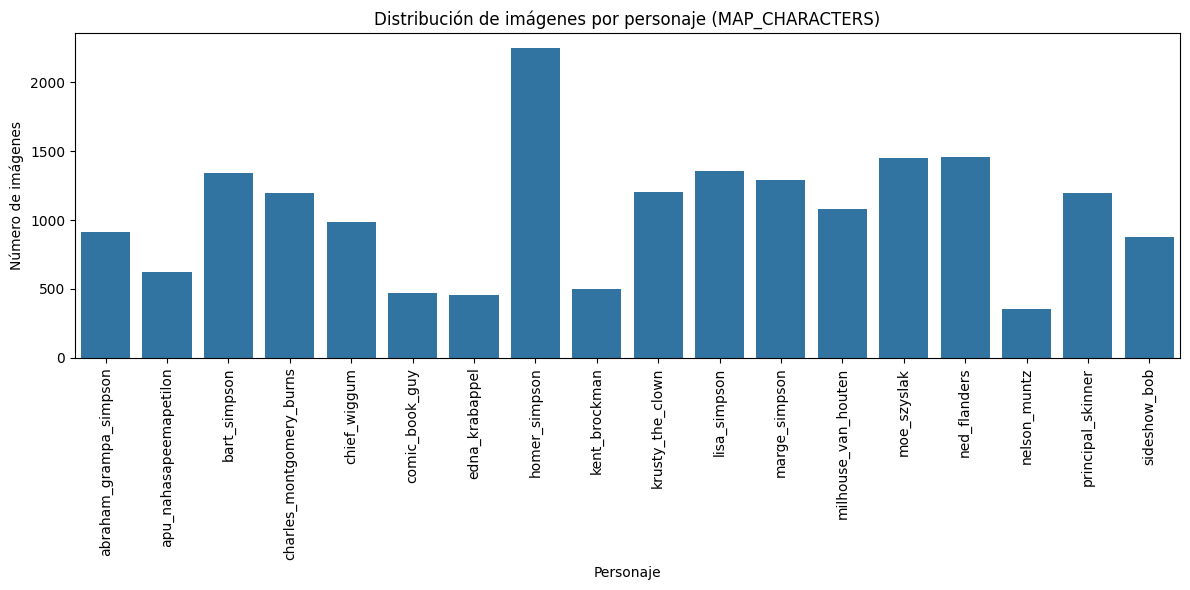

In [ ]:
# Contar cuántas veces aparece cada clase
counter = Counter(y)

# Obtener los nombres desde el diccionario
labels = [MAP_CHARACTERS[i] for i in counter.keys()]
counts = [counter[i] for i in counter.keys()]

# Visualizar con seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=counts)
plt.xticks(rotation=90)
plt.title("Distribución de imágenes por personaje (MAP_CHARACTERS)")
plt.xlabel("Personaje")
plt.ylabel("Número de imágenes")
plt.tight_layout()
plt.show()

In [ ]:
# Inicializar conteo
class_counts = {}

# Calcular número de imágenes por clase en MAP_CHARACTERS
for label, character in MAP_CHARACTERS.items():
    char_path = os.path.join(DATASET_TRAIN_PATH_COLAB, character)
    images = [f for f in os.listdir(char_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[character] = len(images)

# Mostrar conteo actual
print("📊 Conteo inicial de imágenes por clase:")
for character, count in class_counts.items():
    print(f"{character}: {count}")

# Calcular el promedio como objetivo
TARGET_COUNT = int(np.mean(list(class_counts.values())))
print(f"\n🎯 Se usarán {TARGET_COUNT} imágenes como objetivo por clase.")

📊 Conteo inicial de imágenes por clase:
abraham_grampa_simpson: 913
apu_nahasapeemapetilon: 623
bart_simpson: 1342
charles_montgomery_burns: 1193
chief_wiggum: 986
comic_book_guy: 469
edna_krabappel: 457
homer_simpson: 2246
kent_brockman: 498
krusty_the_clown: 1206
lisa_simpson: 1354
marge_simpson: 1291
milhouse_van_houten: 1079
moe_szyslak: 1452
ned_flanders: 1454
nelson_muntz: 358
principal_skinner: 1194
sideshow_bob: 877

🎯 Se usarán 1055 imágenes como objetivo por clase.


**10. Aumento de Datos (Data Augmentation)**

---

Se aplica aumento de datos utilizando la clase ImageDataGenerator de Keras. Esto genera versiones modificadas de las imágenes de entrenamiento (rotadas, desplazadas, etc.) para aumentar la diversidad del conjunto de datos y mejorar la generalización del modelo.

In [ ]:
# Definir generador de aumento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Balanceo por clase con mensajes por clase
for label, character in MAP_CHARACTERS.items():
    char_path = os.path.join(DATASET_TRAIN_PATH_COLAB, character)
    images = [f for f in os.listdir(char_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    current_count = len(images)
    if current_count >= TARGET_COUNT:
        print(f"✅ {character}: ya tiene {current_count} imágenes. No se necesita aumento.")
        continue

    # Cargar imágenes originales
    originals = []
    for fname in images:
        img = cv2.imread(os.path.join(char_path, fname))
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            originals.append(img)

    if not originals:
        print(f"⚠️ {character}: sin imágenes válidas. Saltando.")
        continue

    originals = np.array(originals)
    originals = originals.reshape((-1, IMG_SIZE, IMG_SIZE, 3))

    missing = TARGET_COUNT - current_count
    print(f"🌀 {character}: generando {missing} imágenes adicionales para llegar a {TARGET_COUNT}...")

    gen = datagen.flow(
        originals,
        batch_size=1,
        save_to_dir=char_path,
        save_prefix=f"{character}_aug",
        save_format="jpeg"
    )

    for i in range(missing):
        next(gen)  # genera y guarda

    print(f"✅ {character}: aumento completado.\n")


🌀 abraham_grampa_simpson: generando 142 imágenes adicionales para llegar a 1055...
✅ abraham_grampa_simpson: aumento completado.

🌀 apu_nahasapeemapetilon: generando 432 imágenes adicionales para llegar a 1055...
✅ apu_nahasapeemapetilon: aumento completado.

✅ bart_simpson: ya tiene 1342 imágenes. No se necesita aumento.
✅ charles_montgomery_burns: ya tiene 1193 imágenes. No se necesita aumento.
🌀 chief_wiggum: generando 69 imágenes adicionales para llegar a 1055...
✅ chief_wiggum: aumento completado.

🌀 comic_book_guy: generando 586 imágenes adicionales para llegar a 1055...
✅ comic_book_guy: aumento completado.

🌀 edna_krabappel: generando 598 imágenes adicionales para llegar a 1055...
✅ edna_krabappel: aumento completado.

✅ homer_simpson: ya tiene 2246 imágenes. No se necesita aumento.
🌀 kent_brockman: generando 557 imágenes adicionales para llegar a 1055...
✅ kent_brockman: aumento completado.

✅ krusty_the_clown: ya tiene 1206 imágenes. No se necesita aumento.
✅ lisa_simpson: ya

In [ ]:
# ✅ Recontar imágenes por clase después del aumento
final_counts = {}
for label, character in MAP_CHARACTERS.items():
    char_path = os.path.join(DATASET_TRAIN_PATH_COLAB, character)
    imgs = [f for f in os.listdir(char_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    final_counts[character] = len(imgs)

# Mostrar resultados finales
print("\n📈 Distribución final de imágenes por clase:")
sorted_counts = sorted(final_counts.items(), key=lambda x: x[1], reverse=True)
for character, count in sorted_counts:
    print(f"{character}: {count} imágenes")

print(f"\n✅ Total de clases: {len(final_counts)}")
print(f"📷 Total de imágenes en el dataset: {sum(final_counts.values())}")


📈 Distribución final de imágenes por clase:
homer_simpson: 2246 imágenes
ned_flanders: 1454 imágenes
moe_szyslak: 1452 imágenes
lisa_simpson: 1354 imágenes
bart_simpson: 1342 imágenes
marge_simpson: 1291 imágenes
krusty_the_clown: 1206 imágenes
principal_skinner: 1194 imágenes
charles_montgomery_burns: 1193 imágenes
milhouse_van_houten: 1079 imágenes
abraham_grampa_simpson: 1055 imágenes
apu_nahasapeemapetilon: 1055 imágenes
chief_wiggum: 1055 imágenes
comic_book_guy: 1055 imágenes
edna_krabappel: 1055 imágenes
kent_brockman: 1055 imágenes
nelson_muntz: 1055 imágenes
sideshow_bob: 1055 imágenes

✅ Total de clases: 18
📷 Total de imágenes en el dataset: 22251


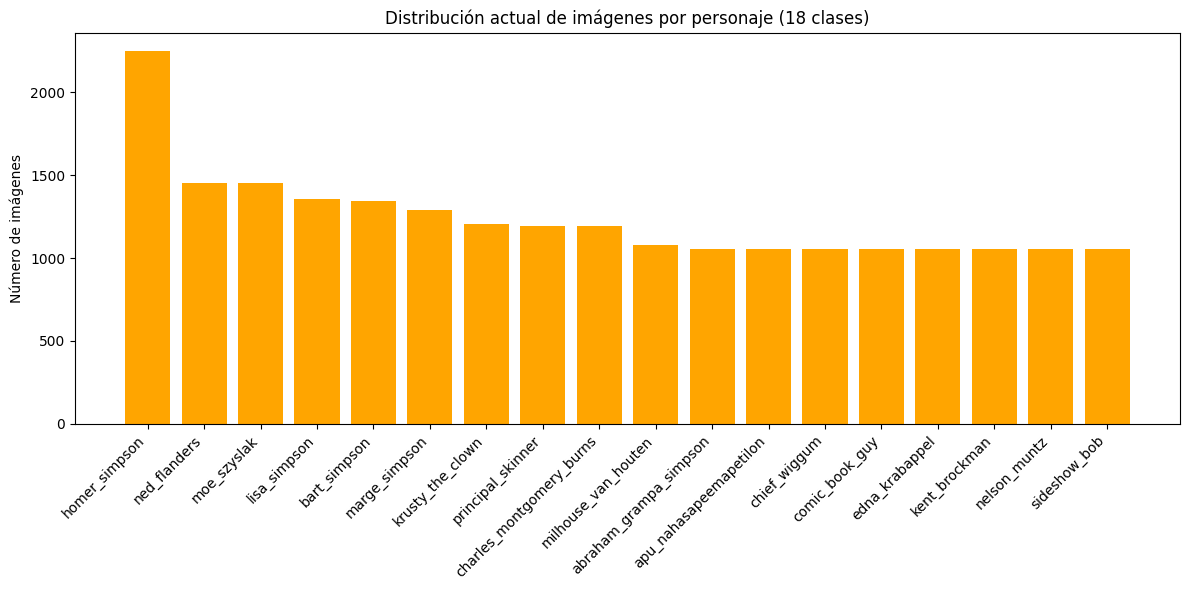

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar([char for char, _ in sorted_counts], [count for _, count in sorted_counts], color='orange')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Número de imágenes")
plt.title("Distribución actual de imágenes por personaje (18 clases)")
plt.tight_layout()
plt.show()

In [ ]:
# Información básica del conjunto de datos
print(f"Forma de x_train: {X.shape}")
print(f"Forma de y_train: {y.shape}")
print(f"Forma de x_test: {X_t.shape}")
print(f"Forma de y_test: {y_t.shape}")

# Imprimir rango de valores de píxeles
print(f"Valor mínimo de píxel: {X.min()}")
print(f"Valor máximo de píxel: {X.max()}")
print(f"Tipo de datos: {X.dtype}")

Forma de x_train: (18992, 64, 64, 3)
Forma de y_train: (18992,)
Forma de x_test: (890, 64, 64, 3)
Forma de y_test: (890,)
Valor mínimo de píxel: 0
Valor máximo de píxel: 255
Tipo de datos: uint8


**11. Preprocesamiento de Datos:**

---

Se preprocesan los datos para prepararlos para el entrenamiento del modelo. Esto incluye la normalización de los valores de los píxeles al rango de 0 a 1 y la codificación one-hot de las etiquetas de clase. Además, se divide el conjunto de entrenamiento en subconjuntos de entrenamiento y validación.

In [ ]:
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

In [ ]:
# Convertimos a tipo float32 y dividimos por 255
X = X.astype('float32') / 255.0
X_t = X_t.astype('float32') / 255.0

In [ ]:
print(f"Número de clases detectadas: {len(MAP_CHARACTERS)}")
print(f"Clases: {list(MAP_CHARACTERS.values())}")

Número de clases detectadas: 18
Clases: ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'principal_skinner', 'sideshow_bob']


In [ ]:
# One-hot encode
y_cat = to_categorical(y, num_classes=len(MAP_CHARACTERS))

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y
)

**12. Definición del Modelo CNN:**

---

Se define la arquitectura del modelo CNN utilizando Keras. El modelo incluye capas convolucionales para extraer características, capas de pooling para reducir la dimensionalidad, capas de normalización y dropout para regularización, y capas densas para la clasificación final. Se compila el modelo especificando el optimizador, la función de pérdida y las métricas de evaluación.

Se utilizan callbacks durante el entrenamiento. EarlyStopping detiene el entrenamiento si el rendimiento en el conjunto de validación deja de mejorar, y ModelCheckpoint guarda el mejor modelo obtenido durante el entrenamiento.

In [ ]:
# Ruta de archivos
MODEL_PATH = "mejor_modelo.h5"
WEIGHTS_PATH = "mejores_pesos.weights.h5"
# Si existe el modelo completo guardado, lo cargamos
if os.path.exists(MODEL_PATH):
    print("Cargando modelo completo desde archivo...")
    model = load_model(MODEL_PATH)
# Si existen solo los pesos, cargamos pesos en arquitectura definida
if os.path.exists(WEIGHTS_PATH):
    print("Cargando arquitectura y pesos...")
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dense(len(MAP_CHARACTERS), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights(WEIGHTS_PATH)

# Si no existe nada, creamos y entrenamos el modelo desde cero
else:
    print("Creando y entrenando nuevo modelo...")

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dense(len(MAP_CHARACTERS), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    checkpoint_model = ModelCheckpoint(
        filepath=MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    checkpoint_weights = ModelCheckpoint(
        filepath=WEIGHTS_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )


Creando y entrenando nuevo modelo...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Resumen del modelo
model.build(input_shape=(None, 64, 64, 3))
model.summary()

# Visualizar la arquitectura del modelo de forma clara
print("\nArquitectura del modelo:")
for i, layer in enumerate(model.layers):
    print(f"Capa {i}: {layer.name}")
    print(f"  - Tipo: {layer.__class__.__name__}")

    # Verificar y mostrar la forma de salida
    try:
        print(f"  - Forma de salida: {layer.output_shape}")
    except AttributeError:
        print(f"  - Forma de salida: No disponible")

    # Mostrar función de activación si aplica
    if hasattr(layer, 'activation') and hasattr(layer.activation, '__name__'):
        print(f"  - Función de activación: {layer.activation.__name__}")

    # Detalles específicos de capas Dense
    if isinstance(layer, Dense):
        print(f"  - Número de parámetros: {layer.count_params()}")
        print(f"  - Número de neuronas: {layer.units}")

    # Detalles de capas Dropout
    if isinstance(layer, Dropout):
        print(f"  - Tasa de dropout: {layer.rate}")

    print()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,277,778 (4.87 MB)

 Trainable params: 1,277,778 (4.87 MB)

 Non-trainable params: 0 (0.00 B)


Arquitectura del modelo:
Capa 0: conv2d
  - Tipo: Conv2D
  - Forma de salida: No disponible
  - Función de activación: relu

Capa 1: max_pooling2d
  - Tipo: MaxPooling2D
  - Forma de salida: No disponible

Capa 2: conv2d_1
  - Tipo: Conv2D
  - Forma de salida: No disponible
  - Función de activación: relu

Capa 3: max_pooling2d_1
  - Tipo: MaxPooling2D
  - Forma de salida: No disponible

Capa 4: conv2d_2
  - Tipo: Conv2D
  - Forma de salida: No disponible
  - Función de activación: relu

Capa 5: max_pooling2d_2
  - Tipo: MaxPooling2D
  - Forma de salida: No disponible

Capa 6: flatten
  - Tipo: Flatten
  - Forma de salida: No disponible

Capa 7: dropout
  - Tipo: Dropout
  - Forma de salida: No disponible
  - Tasa de dropout: 0.5

Capa 8: dense
  - Tipo: Dense
  - Forma de salida: No disponible
  - Función de activación: relu
  - Número de parámetros: 1179904
  - Número de neuronas: 256

Capa 9: dense_1
  - Tipo: Dense
  - Forma de salida: No disponible
  - Función de activación: soft

**13. Entrenamiento del Modelo:**

---

Se entrena el modelo utilizando el método fit() con los generadores de datos definidos anteriormente, especificando el número de épocas, los pasos por época y los datos de validación.

In [ ]:
    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint_model, checkpoint_weights]
    )

Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2462 - loss: 2.4145
Epoch 1: val_accuracy improved from -inf to 0.55646, saving model to mejor_modelo.h5



Epoch 1: val_accuracy improved from -inf to 0.55646, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.2468 - loss: 2.4130 - val_accuracy: 0.5565 - val_loss: 1.4740
Epoch 2/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5885 - loss: 1.3746
Epoch 2: val_accuracy improved from 0.55646 to 0.67491, saving model to mejor_modelo.h5



Epoch 2: val_accuracy improved from 0.55646 to 0.67491, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5890 - loss: 1.3728 - val_accuracy: 0.6749 - val_loss: 1.0868
Epoch 3/100
235/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6967 - loss: 0.9966
Epoch 3: val_accuracy improved from 0.67491 to 0.74309, saving model to mejor_modelo.h5



Epoch 3: val_accuracy improved from 0.67491 to 0.74309, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6969 - loss: 0.9960 - val_accuracy: 0.7431 - val_loss: 0.8714
Epoch 4/100
233/238 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7686 - loss: 0.7666
Epoch 4: val_accuracy improved from 0.74309 to 0.77231, saving model to mejor_modelo.h5



Epoch 4: val_accuracy improved from 0.74309 to 0.77231, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7686 - loss: 0.7663 - val_accuracy: 0.7723 - val_loss: 0.7526
Epoch 5/100
235/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8234 - loss: 0.5712
Epoch 5: val_accuracy improved from 0.77231 to 0.79653, saving model to mejor_modelo.h5



Epoch 5: val_accuracy improved from 0.77231 to 0.79653, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8234 - loss: 0.5712 - val_accuracy: 0.7965 - val_loss: 0.6794
Epoch 6/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8517 - loss: 0.4683
Epoch 6: val_accuracy improved from 0.79653 to 0.82364, saving model to mejor_modelo.h5



Epoch 6: val_accuracy improved from 0.79653 to 0.82364, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8517 - loss: 0.4684 - val_accuracy: 0.8236 - val_loss: 0.6047
Epoch 7/100
235/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8890 - loss: 0.3547
Epoch 7: val_accuracy improved from 0.82364 to 0.83127, saving model to mejor_modelo.h5



Epoch 7: val_accuracy improved from 0.82364 to 0.83127, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8889 - loss: 0.3549 - val_accuracy: 0.8313 - val_loss: 0.5858
Epoch 8/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9083 - loss: 0.2943
Epoch 8: val_accuracy improved from 0.83127 to 0.83759, saving model to mejor_modelo.h5



Epoch 8: val_accuracy improved from 0.83127 to 0.83759, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9082 - loss: 0.2945 - val_accuracy: 0.8376 - val_loss: 0.5929
Epoch 9/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9254 - loss: 0.2314
Epoch 9: val_accuracy improved from 0.83759 to 0.84391, saving model to mejor_modelo.h5



Epoch 9: val_accuracy improved from 0.83759 to 0.84391, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9253 - loss: 0.2315 - val_accuracy: 0.8439 - val_loss: 0.5786
Epoch 10/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9448 - loss: 0.1788
Epoch 10: val_accuracy improved from 0.84391 to 0.85233, saving model to mejor_modelo.h5



Epoch 10: val_accuracy improved from 0.84391 to 0.85233, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9448 - loss: 0.1788 - val_accuracy: 0.8523 - val_loss: 0.5820
Epoch 11/100
232/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9470 - loss: 0.1648
Epoch 11: val_accuracy did not improve from 0.85233

Epoch 11: val_accuracy did not improve from 0.85233
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9470 - loss: 0.1648 - val_accuracy: 0.8439 - val_loss: 0.6448
Epoch 12/100
233/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9527 - loss: 0.1427
Epoch 12: val_accuracy did not improve from 0.85233

Epoch 12: val_accuracy did not improve from 0.85233
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9527 - loss: 0.1428 - val_accuracy: 0.8502 - val_loss: 0.6386
Epoch 13/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9594 - loss: 0.1250
Epoch 13: val_accuracy improved from 0.85233 to 0.85654, saving model to 


Epoch 13: val_accuracy improved from 0.85233 to 0.85654, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9593 - loss: 0.1251 - val_accuracy: 0.8565 - val_loss: 0.6166
Epoch 14/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9642 - loss: 0.1108
Epoch 14: val_accuracy improved from 0.85654 to 0.85812, saving model to mejor_modelo.h5



Epoch 14: val_accuracy improved from 0.85654 to 0.85812, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9642 - loss: 0.1108 - val_accuracy: 0.8581 - val_loss: 0.6327
Epoch 15/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9678 - loss: 0.0977 
Epoch 15: val_accuracy did not improve from 0.85812

Epoch 15: val_accuracy did not improve from 0.85812
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9678 - loss: 0.0977 - val_accuracy: 0.8558 - val_loss: 0.6419
Epoch 16/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9634 - loss: 0.1017
Epoch 16: val_accuracy did not improve from 0.85812

Epoch 16: val_accuracy did not improve from 0.85812
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9634 - loss: 0.1018 - val_accuracy: 0.8560 - val_loss: 0.6252
Epoch 17/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9711 - loss: 0.0910
Epoch 17: val_accuracy did not improve from 0.85812

Epoch 17: val_accur


Epoch 18: val_accuracy improved from 0.85812 to 0.85944, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9717 - loss: 0.0915 - val_accuracy: 0.8594 - val_loss: 0.6499
Epoch 19/100
233/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9777 - loss: 0.0710
Epoch 19: val_accuracy improved from 0.85944 to 0.86312, saving model to mejor_modelo.h5



Epoch 19: val_accuracy improved from 0.85944 to 0.86312, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9776 - loss: 0.0712 - val_accuracy: 0.8631 - val_loss: 0.6614
Epoch 20/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9804 - loss: 0.0622
Epoch 20: val_accuracy did not improve from 0.86312

Epoch 20: val_accuracy did not improve from 0.86312
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9803 - loss: 0.0624 - val_accuracy: 0.8523 - val_loss: 0.7384
Epoch 21/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9741 - loss: 0.0806
Epoch 21: val_accuracy did not improve from 0.86312

Epoch 21: val_accuracy did not improve from 0.86312
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9741 - loss: 0.0806 - val_accuracy: 0.8610 - val_loss: 0.7092
Epoch 22/100
237/238 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9763 - loss: 0.0773
Epoch 22: val_accuracy improved from 0.86312 to 0.86628, saving model to


Epoch 22: val_accuracy improved from 0.86312 to 0.86628, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9763 - loss: 0.0773 - val_accuracy: 0.8663 - val_loss: 0.6376
Epoch 23/100
237/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9823 - loss: 0.0551
Epoch 23: val_accuracy did not improve from 0.86628

Epoch 23: val_accuracy did not improve from 0.86628
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9823 - loss: 0.0552 - val_accuracy: 0.8555 - val_loss: 0.7308
Epoch 24/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9808 - loss: 0.0572
Epoch 24: val_accuracy did not improve from 0.86628

Epoch 24: val_accuracy did not improve from 0.86628
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9808 - loss: 0.0572 - val_accuracy: 0.8618 - val_loss: 0.7137
Epoch 25/100
233/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9754 - loss: 0.0715
Epoch 25: val_accuracy did not improve from 0.86628

Epoch 25: val_accura


Epoch 30: val_accuracy improved from 0.86628 to 0.86865, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9803 - loss: 0.0564 - val_accuracy: 0.8686 - val_loss: 0.7288
Epoch 31/100
235/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9827 - loss: 0.0511
Epoch 31: val_accuracy did not improve from 0.86865

Epoch 31: val_accuracy did not improve from 0.86865
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9827 - loss: 0.0511 - val_accuracy: 0.8600 - val_loss: 0.7446
Epoch 32/100
233/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9870 - loss: 0.0422
Epoch 32: val_accuracy did not improve from 0.86865

Epoch 32: val_accuracy did not improve from 0.86865
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9869 - loss: 0.0424 - val_accuracy: 0.8660 - val_loss: 0.7459
Epoch 33/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9843 - loss: 0.0493
Epoch 33: val_accuracy did not improve from 0.86865

Epoch 33: val_accur


Epoch 34: val_accuracy improved from 0.86865 to 0.87102, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9827 - loss: 0.0548 - val_accuracy: 0.8710 - val_loss: 0.6614
Epoch 35/100
233/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9857 - loss: 0.0455
Epoch 35: val_accuracy did not improve from 0.87102

Epoch 35: val_accuracy did not improve from 0.87102
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9856 - loss: 0.0456 - val_accuracy: 0.8508 - val_loss: 0.7978
Epoch 36/100
234/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9868 - loss: 0.0408
Epoch 36: val_accuracy did not improve from 0.87102

Epoch 36: val_accuracy did not improve from 0.87102
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9868 - loss: 0.0409 - val_accuracy: 0.8686 - val_loss: 0.6969
Epoch 37/100
233/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9870 - loss: 0.0449
Epoch 37: val_accuracy did not improve from 0.87102

Epoch 37: val_accura


Epoch 39: val_accuracy improved from 0.87102 to 0.87839, saving model to mejores_pesos.weights.h5
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9866 - loss: 0.0417 - val_accuracy: 0.8784 - val_loss: 0.6806
Epoch 40/100
235/238 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9842 - loss: 0.0447
Epoch 40: val_accuracy did not improve from 0.87839

Epoch 40: val_accuracy did not improve from 0.87839
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9842 - loss: 0.0448 - val_accuracy: 0.8721 - val_loss: 0.7040
Epoch 41/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9878 - loss: 0.0354
Epoch 41: val_accuracy did not improve from 0.87839

Epoch 41: val_accuracy did not improve from 0.87839
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9878 - loss: 0.0354 - val_accuracy: 0.8650 - val_loss: 0.8001
Epoch 42/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9846 - loss: 0.0574
Epoch 42: val_accuracy did not improve from 0.87839

Epoch 42: val_accur

**14. Evaluación del Modelo:**

---

Finalmente, se evalúa el modelo entrenado. Se carga el mejor modelo guardado, se realizan predicciones sobre el conjunto de prueba y se calculan métricas de rendimiento como la precisión, el informe de clasificación y la matriz de confusión. La matriz de confusión se visualiza gráficamente para entender mejor los errores de clasificación del modelo.

In [ ]:
def mostrar_historial_entrenamiento(history):
    """Muestra gráficamente la evolución de las métricas durante el proceso de entrenamiento."""

    if history is None or not hasattr(history, "history"):
        print("⚠️ No se puede mostrar el historial: no hay historial de entrenamiento disponible.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Evolución de la pérdida
    ax1.plot(history.history['loss'], label='Entrenamiento')
    ax1.plot(history.history['val_loss'], label='Validación')
    ax1.set_title('Evolución de la pérdida')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)

    # Evolución de la precisión
    ax2.plot(history.history['accuracy'], label='Entrenamiento')
    ax2.plot(history.history['val_accuracy'], label='Validación')
    ax2.set_title('Evolución de la precisión')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Resumen de métricas clave
    epoca_max_val = np.argmax(history.history['val_accuracy'])
    acc_max_val = history.history['val_accuracy'][epoca_max_val]
    acc_final_entrenamiento = history.history['accuracy'][-1]
    acc_final_validacion = history.history['val_accuracy'][-1]

    print(f"🔹 Precisión máxima en validación: {acc_max_val:.4f} en la época {epoca_max_val+1}")
    print(f"🔹 Precisión final en entrenamiento: {acc_final_entrenamiento:.4f}")
    print(f"🔹 Precisión final en validación: {acc_final_validacion:.4f}")


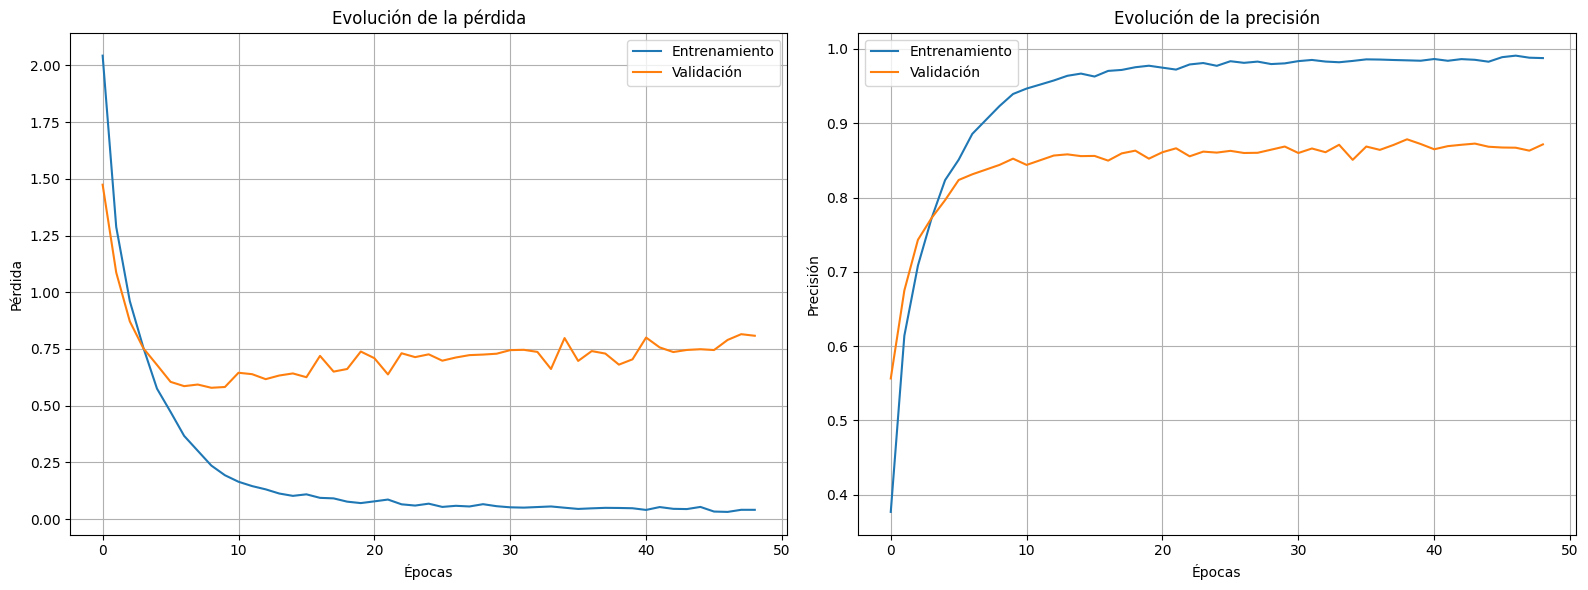

🔹 Precisión máxima en validación: 0.8784 en la época 39
🔹 Precisión final en entrenamiento: 0.9877
🔹 Precisión final en validación: 0.8715

🚨 Indicio de sobreajuste: el modelo rinde mejor en entrenamiento que en validación.
   Recomendaciones: aumentar regularización, usar más dropout o recopilar más datos.


In [ ]:
# Llamada segura (solo si entrenaste)
if 'history' in locals():
    mostrar_historial_entrenamiento(history)
else:
    print("🔸 No se entrenó el modelo en esta sesión, por lo tanto no hay historial para mostrar.")


In [ ]:
predicciones = model.predict(X_val)
pred_clases = np.argmax(predicciones, axis=1)

print("Distribución de clases predichas:")
unique_preds, pred_counts = np.unique(pred_clases, return_counts=True)
for label, count in zip(unique_preds, pred_counts):
    print(f"Clase {label} ({MAP_CHARACTERS[label]}): {count} muestras")


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Distribución de clases predichas:
Clase 0 (abraham_grampa_simpson): 171 muestras
Clase 1 (apu_nahasapeemapetilon): 128 muestras
Clase 2 (bart_simpson): 250 muestras
Clase 3 (charles_montgomery_burns): 226 muestras
Clase 4 (chief_wiggum): 199 muestras
Clase 5 (comic_book_guy): 84 muestras
Clase 6 (edna_krabappel): 89 muestras
Clase 7 (homer_simpson): 462 muestras
Clase 8 (kent_brockman): 97 muestras
Clase 9 (krusty_the_clown): 244 muestras
Clase 10 (lisa_simpson): 266 muestras
Clase 11 (marge_simpson): 270 muestras
Clase 12 (milhouse_van_houten): 203 muestras
Clase 13 (moe_szyslak): 304 muestras
Clase 14 (ned_flanders): 286 muestras
Clase 15 (nelson_muntz): 86 muestras
Clase 16 (principal_skinner): 257 muestras
Clase 17 (sideshow_bob): 177 muestras


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluar el modelo en el conjunto de prueba
print("======== Resumen del Modelo CNN ========")
test_loss, test_accuracy = model.evaluate(X_t, to_categorical(y_t, num_classes=len(MAP_CHARACTERS)), verbose=0)
print(f"🔍 Exactitud final en el conjunto de prueba: {test_accuracy * 100:.2f}%")
print(f"📉 Pérdida final en el conjunto de prueba: {test_loss:.4f}")

# Predicciones
y_pred = np.argmax(model.predict(X_t), axis=1)
y_true = y_t  # etiquetas reales en forma entera

# Exactitud global
print(f"\n🎯 Exactitud total: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# Reporte detallado
print("\n📊 Clasificación por clase:")
print(classification_report(y_true, y_pred, target_names=list(MAP_CHARACTERS.values())))


======== Resumen del Modelo CNN ========
🔍 Exactitud final en el conjunto de prueba: 97.64%
📉 Pérdida final en el conjunto de prueba: 0.1156
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🎯 Exactitud total: 97.64%

📊 Clasificación por clase:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.98      0.99        48
  apu_nahasapeemapetilon       1.00      1.00      1.00        50
            bart_simpson       0.96      0.98      0.97        50
charles_montgomery_burns       0.98      0.96      0.97        48
            chief_wiggum       1.00      1.00      1.00        50
          comic_book_guy       1.00      0.86      0.92        49
          edna_krabappel       0.98      0.96      0.97        50
           homer_simpson       0.91      0.98      0.94        50
           kent_brockman       1.00      1.00      1.00        50
        krusty_the_clown       1.00      0.98      0.99        50
            lisa_simpson       1.00  